# Prototype for analytical model classes

The aim of this worksheet is to experiment and design a set of classes for expressing analytical models for well test interpretation. The general idea is that there should be a parent generic class and a set of derived classes allowing to avoid repeating code.

In this first prototype, I consider only the generic parent class and two daughter classes.

Nov. 7 2019 - P. Renard

Nov. 20 2019 - N. Dutler (noflow, consthead incl. laplace)

Dec. 14 2019 - N. Dutler (Cooper-Bredehoeft-Papadopulos)

Dec. 30 2019 - N. Dutler (Report, self operator includes now all solutions and statistics from fit)

Jan. 10 2020 - N. Dutler (Jacob-Lohman, Demo Theis, change preprocessing to class)

Feb. 10 2020 - N. Dutler (GRF)

Apr. .. 2020 - N. Dutller (Argrawal time, Birsoy time, Warren&Root)

Jun. 15 2020 - N. Dutler (stehfest, dehoog, many changes related to fit function to speed up the calculations)


In [1]:
%matplotlib inline
import sys
sys.path.append("..")
import openhytest as ht
import mpmath as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.special import factorial

In [2]:
# Read a data set to test ideas
df1 = pd.read_csv('../data/ths_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df2 = pd.read_csv('../data/thn_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df3 = pd.read_csv('../data/thc_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df4 = pd.read_csv('../data/pca_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df5 = pd.read_csv('../data/jlq_ds1.txt', header=None,sep=" ",names=['t','q'], dtype={'t': 'float64', 'q': 'float64'})
df6 = pd.read_csv('../data/tmc_ds1.txt', header=None,sep="  ",names=['t','q'], dtype={'t': 'float64', 'q': 'float64'})
df7 = pd.read_csv('../data/tmr_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})

/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Below is the part where the classes are defined in order to test the concept.

The first thing is to define a generic class AnalyticalModels of analytical models that should contain all the generic functionalities.  Then, we derive two examples of daughter classes: the theis and theis_noflow models. 

The theis_noflow model is wrong (wrong equations and parametrizations and needs to be corrected), but the principle seems to work.

The next steps would be to implement:
- the fit function
- one or a pair of examples with laplace domain solution


../openhytest/modelclasses.py:2476: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim((0, 10))


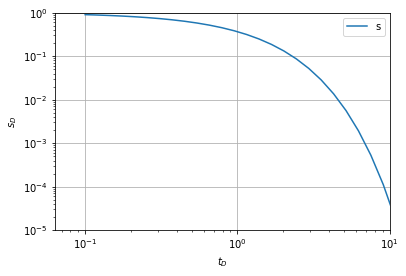

In [3]:
slug = ht.Hvorslev()
slug.plot_typecurve()

# How to create a type curve

In [ ]:
abaque = ht.Theis()
abaque.plot_typecurve()

In [ ]:
td = np.logspace(-1, 4)
abaque.fitcoeff = 12
abaque._coeff()
sd = abaque._laplace_drawdown(td, inversion_option='stehfest')
sd4 = abaque._laplace_drawdown(td, inversion_option='dehoog')
plt.loglog(td, sd)
#dev = ht.ldiffs(pd.DataFrame({'td':td, 'sd':sd}))
dd = abaque._laplace_drawdown_derivative(td, inversion_option='stehfest')
dd4 = abaque._laplace_drawdown_derivative(td, inversion_option='dehoog')
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.plot(td,dd, '--')
plt.xlim((1e-1, 1e4))
plt.ylim((1e-2, 1e1))
plt.grid('True')

In [ ]:
#Stehfest check
M = np.int(12)
V = np.zeros(M)
for i in range(1,M+1):
    vi = 0
    for k in range(np.int((i+1)/2),np.int(np.min([i,M/2]))+1):
        vi = vi + (k**(M/2)*factorial(2*k))/(factorial(np.int(M/2-k))*factorial(k)*factorial(k-1)*factorial(i-k)*factorial(2*k-i))
    V[i-1] = (-1) ** ((M/2)+i)*vi
print(V)

In [ ]:
p = np.zeros([M, np.size(td)])
for i in range(1,M+1):
    p[i-1] = i*np.log(2)/td
uu = abaque.dimensionless_laplace(p)
VV = np.repeat(V, np.size(td)).reshape(M,np.size(td))
su = np.multiply(VV, uu)
s = np.log(2)/td*sum(su)
print(s)

In [ ]:
sd2 = abaque.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

In [ ]:
dd2 = abaque.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

In [ ]:
#dehoog check
alpha = 0
tol = 1e-9
M = 20 
logallt = np.log10(td)
iminlogallt = np.floor(np.min(logallt))
imaxlogallt = np.ceil(np.max(logallt))
f = []
for ilogt in range(np.int(iminlogallt), np.int(imaxlogallt)+1):
    t = td[((logallt>=ilogt) & (logallt<(ilogt+1)))]
    if t is not None:
        T = 2 * np.max(t)
        gamma = alpha - np.log(tol) / (2*T)
        run = np.linspace(0,2*M, 2*M+1)
        p = gamma + 1j * np.pi * run / T    
        a = abaque.dimensionless_laplace(p)#Fp(p);      # evaluate function
        a[0] = a[0] / 2 # zero term is halved
        # build up e and q tables.
        e = np.zeros((2*M+1, M+1), dtype=complex)
        q = np.zeros((2*M, M+1), dtype=complex)
        q[:,1] = a[1:2*M+1]/a[0:2*M]
        for r in np.arange(1,M+1):
            e[0:2*(M-r)+1,r] = q[1:2*(M-r)+2,r] - q[0:2*(M-r)+1,r] + e[1:2*(M-r)+2,r-1]
            if r < M:
                rq = r + 1
                q[0:2*(M-rq)+2,rq] = q[1:2*(M-rq)+3,rq-1]*e[1:2*(M-rq)+3,rq-1]/e[0:2*(M-rq)+2,rq-1]
        # build up d vector  
        d = np.zeros((2*M+1,1), dtype=complex)
        d[0] = a[0]
        d[1:2*M:2] = np.vstack(-q[0,1:M+1])
        d[2:2*M+1:2] = np.vstack(-e[0,1:M+1])
        # build up A and B matrix
        A = np.zeros((2*M+2,len(t)), dtype=complex)
        B = np.zeros((2*M+2,len(t)), dtype=complex)
        A[1,:] = d[0,0]*np.ones((1,len(t)))
        B[0,:] = np.ones((1,len(t)))
        B[1,:] = np.ones((1,len(t)))
        z = np.exp(1j*np.pi*t/T)
        for n in np.arange(2, 2*M+2):
            A[n,:] = A[n-1,:] + d[n-1]*np.ones((1,len(t)))*z*A[n-2,:]
            B[n,:] = B[n-1,:] + d[n-1]*np.ones((1,len(t)))*z*B[n-2,:]
            
        h2M = .5 * ( np.ones((1,len(t))) + ( d[2*M-1]-d[2*M] ) * np.ones((1,len(t))) * z )
        R2Mz = -h2M*(np.ones((1,len(t))) - (np.ones((1,len(t))) + d[2*M]*np.ones((1,len(t))) * z / h2M ** 2) ** 5)
        A[2*M+1,:] = A[2*M,:] + R2Mz * A[2*M-1,:]
        B[2*M+1,:] = B[2*M,:] + R2Mz * B[2*M-1,:]
        fpiece = np.array(1/T * np.exp(gamma * t) * np.real(A[2*M+1,:] / B[2*M+1,:]))
        f = np.append(f, np.hstack(fpiece))
print(f)

In [ ]:
residual = sd4-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

residual2 = dd4-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

# How to adjust a Theis model using guess_params and the fit function

In [ ]:
apaque= ht.Theis(Q=1.3888e-2, r=250, df=df1)
p = apaque.guess_params()
print("estimated parameter vector:",p)
apaque.trial()

In [ ]:
p = apaque.fit(fitmethod='lm')
print(p)
apaque.trial()

In [ ]:
apaque.rpt(author='N. Dutler', filetype='png')

# Moving to no flow model

In [ ]:
model = ht.Theis_noflow(Rd=33)
model.plot_typecurve()

In [ ]:
td = np.logspace(-2, 5)
sd = model._laplace_drawdown(td, inversion_option='dehoog')
plt.loglog(td, sd)
dd = model._laplace_drawdown_derivative(td, inversion_option='dehoog')
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [ ]:
sd2 = model.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

In [ ]:
dd2 = model.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

In [ ]:
model = ht.Theis_noflow(Q=0.0132,r=20, df=df2)
p = model.guess_params()
print("estimated parameter vector:",p)
model.trial()


In [ ]:
p = model.fit(fitmethod='trf')
p

In [ ]:
model.trial()

In [ ]:
model.rpt(fitmethod='trf')

# Moving to constant head model

In [ ]:
bequer = ht.Theis_constanthead(Rd=33)
bequer.plot_typecurve()

In [ ]:
td = np.logspace(-2, 5)
sdn = bequer._laplace_drawdown(td, inversion_option='dehoog')
sd = list(sdn)
plt.loglog(td, sd)
ddn = bequer._laplace_drawdown_derivative(td, inversion_option='dehoog')
dd = list(ddn)
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [ ]:
sd2 = bequer.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

In [ ]:
dd2 = bequer.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

In [ ]:
bequer = ht.Theis_constanthead(Q=0.030,r=20, df=df3)
p = bequer.guess_params()
print("estimated parameter vector:",p)
bequer.trial()

In [ ]:
p = bequer.fit(option='trf')

In [ ]:
bequer.trial()

In [ ]:
bequer.rpt()

# Cooper-Bredehoeft-Papadopulos (1967) model

In [ ]:
coobredpapa = ht.CooperBredehoeftPapadopulos(r=1, rc=1)
coobredpapa.plot_typecurve()

In [ ]:
coobredpapa= ht.CooperBredehoeftPapadopulos(Q=0.0050472, r=3.048, rw=0.6096, rc=0.6096, df=df4)  
p = coobredpapa.guess_params()
print("estimated parameter vector:",p)

In [ ]:
coobredpapa.trial()

In [ ]:
coobredpapa.rpt()

In [ ]:
coobredpapa= ht.CooperBredehoeftPapadopulos(Q=0.0050472, r=3.048, rw=0.6096, rc=0.6096, cD=50, df=df4)  
coobredpapa.guess_params()
coobredpapa.rpt()

# Jacob-Lohman (1952) model

In [ ]:
jcl = ht.JacobLohman(s=28.142, r=0.084, df = df5)
jcl.plot_typecurve()

In [ ]:
jcl.guess_params()

In [ ]:
jcl.fitcoeff = 16
jcl.rpt()

In [ ]:
Qmat = [[30*60, 500/3600/24], 
        [80*60, 700/3600/24], 
        [130*60, 600/3600/24]]
print(Qmat)
pro=ht.preprocessing(df=df7, Qmat=Qmat)
pro.diagnostic()
aba = ht.Theis(df=df7)

In [ ]:
aba.guess_params()

## GRF Barker (1988)

In [ ]:
genrad = ht.GRF()
genrad.plot_typecurve()